In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data


In [6]:

def _vis_landscapes(
        fig,
        axs: plt.Axes,
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing="ij")

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_xlabel('beta')
        if idx == 0:
            axs[idx].set_ylabel('gamma')
        # else:
        axs[idx].set_yticks([])
        axs[idx].set_xticks([])
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="opt. path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial pt")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged pt")

            axs[idx].legend(loc='upper center')

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))], pad=0.05)
    # plt.legend()
    # fig.tight_layout()

save to  paper_figs/diverge_due_to_bp.pdf


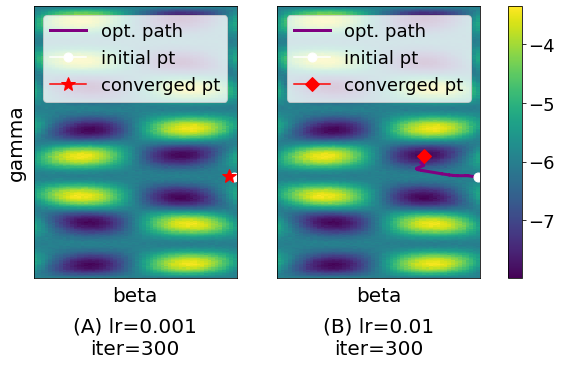

In [7]:
def vis_case1():

    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/opt_on_origin_landscape/2022-10-10_22:44:02/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/opt_on_origin_landscape/2022-10-10_22:42:34/use_case_data.npz",
        allow_pickle=True
    )

    # params_paths = [opt_data1['params_path'].tolist(), opt_data1['params_path'].tolist(), opt_data2['params_path']]
    params_paths = [opt_data1['params_path'].tolist(), opt_data2['params_path']]


    params = {'legend.fontsize': 18,
          'figure.figsize': (10, 5),
         'axes.labelsize': 20, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    labels=["(A) lr=0.001\niter=300", "(B) lr=0.01\niter=300"]
    save_path="paper_figs/diverge_due_to_bp.pdf"
    # _vis_landscapes(
    #     fig,
    #     axs,
    #     landscapes=[origin['unmitis'].transpose(), recon['unmitis'].transpose(), origin['unmitis'].transpose()],
    #     labels=["(A) lr=0.001\niter=300", "(B) Recon.", "(C) lr=0.01\niter=300"],
    #     full_range=full_range,
    #     true_optima=None,
    #     title="Debug poor learning rate (lr) to escape barren plateaus",
    #     save_path="paper_figs/diverge_due_to_bp.pdf",
    #     params_paths=params_paths,
    #     converged_soln_markers=["*", "*", "D"]
    # )

    _vis_landscapes(
        fig,
        axs,
        landscapes=[-origin['unmitis'].transpose(), -origin['unmitis'].transpose()],
        labels=labels,
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr) to escape barren plateaus",
        save_path="paper_figs/diverge_due_to_bp.pdf",
        params_paths=params_paths,
        converged_soln_markers=["*", "D"]
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.3)
    # axs[1].set_title(labels[1], y=-0.3)
    # if save_path != None:
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')
vis_case1()

save to  paper_figs/diverge_not_due_to_bp.pdf


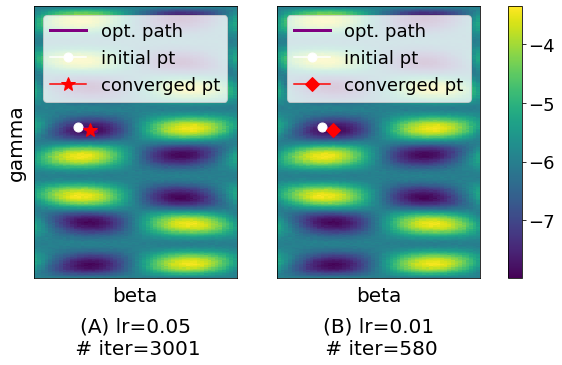

In [8]:
def vis_case2():

    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:15:41/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:11:49/use_case_data.npz",
        allow_pickle=True
    )

    # params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    # _vis_landscapes(
    #     landscapes=[origin['unmitis'], recon['unmitis'], origin['unmitis']],
    #     labels=["lr=0.05\n # iter=3001", "reconstructed", "lr=0.01\n # iter=580"],
    #     full_range=full_range,
    #     true_optima=None,
    #     title="Debug poor learning rate (lr) to reduce iterations",
    #     save_path="paper_figs/case2.png",
    #     params_paths=params_paths,
    #     converged_soln_markers=["*", "*", "D"]
    # )

    params_paths = [opt_data2['params_path'].tolist(), opt_data1['params_path']]
    params = {'legend.fontsize': 18,
          'figure.figsize': (10, 5),
         'axes.labelsize': 20, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    labels=["(A) lr=0.05\n # iter=3001", "(B) lr=0.01\n # iter=580"]
    save_path="paper_figs/diverge_not_due_to_bp.pdf"
    _vis_landscapes(
        fig,
        axs,
        landscapes=[-origin['unmitis'].transpose(), -origin['unmitis'].transpose()],
        labels=labels,
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr) to escape barren plateaus",
        save_path="paper_figs/diverge_due_to_bp.pdf",
        params_paths=params_paths,
        converged_soln_markers=["*", "D"]
    )
    
    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.3)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')


vis_case2()

save to  paper_figs/compare_ADAM_and_SPSA.pdf


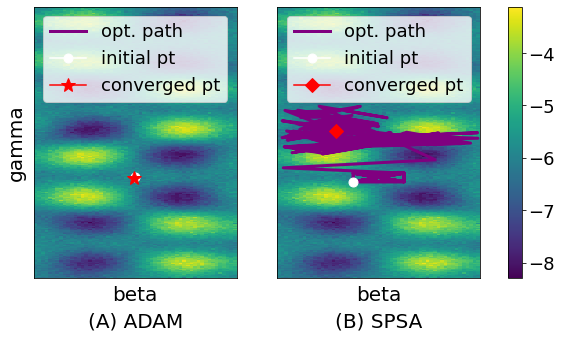

In [10]:
def vis_choose_optimizer():

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    params1 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:52:27/data.npz", allow_pickle=True)['params_path']
    params2 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:55:28/data.npz", allow_pickle=True)['params_path']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/compare_ADAM_and_SPSA.pdf"
    labels=["(A) ADAM", "(B) SPSA"]
    _vis_landscapes(
        fig,
        axs,
        landscapes=[-recon["mitis"].transpose(), -recon["mitis"].transpose()],
        labels=labels,
        full_range=full_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path=save_path,
        params_paths=[params1, params2],
        converged_soln_markers=["*", "D"]
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.2)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

vis_choose_optimizer()

In [ ]:
# n=16

from data_loader import get_recon_landscape, get_recon_pathname, load_grid_search_data


def vis_n16():
    method = 'sv'
    problem = 'maxcut'
    n = 16 # ! largest noisy landscape
    noise = 'depolar-0.001-0.02'
    
    noise_model = None # TODO
    # raise NotImplementedError()

    # n_qubits = 16
    cs_seed = n
    p = 1
    sf = 0.05
    seed = 0
    bs = 50
    gs = 100

    origin_data, data_fname, _ = load_grid_search_data(
        n_qubits=n, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed,
    )

    full_range = origin_data['full_range']
    
    beta_bound = origin_data['beta_bound']
    gamma_bound = origin_data['gamma_bound']

    bounds = np.array([[-gamma_bound, gamma_bound], [-beta_bound, beta_bound]])
    origin = origin_data['data']

    # load recon data
    recon_path, _, _ = get_recon_pathname(p, problem, method, noise, cs_seed, sf, data_fname)
    recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

    # ---------------- load data complete ---------------
    # G = nx.random_regular_graph(3, n, seed)
    # maxcut = Maxcut(G)
    # problem = maxcut.to_quadratic_program()
    # C, offset = problem.to_ising()

    
    opt_data = np.load(
    "figs/debug_barrren_plateaus/2022-11-11_21:42:43/bp-init=[0.78 1.62]-maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100.npz"
    , allow_pickle=True)

    params = opt_data['params_path']

    _vis_landscapes(
        landscapes=[origin, recon],
        labels=["Origin", "Recon"],
        full_range=full_range,
        true_optima=None,
        title="debug barren plateaus",
        # save_path="paper_figs/debug_bp.png",
        save_path=None,
        params_paths=[params, params]
    )
vis_n16()


read grid search data from figs/grid_search/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-depolar-0.001-0.02-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100.npz


TypeError: _vis_landscapes() missing 2 required positional arguments: 'fig' and 'axs'